# Introducció als algoritmes genètics

**Assignatura** : Sistemes d'aprenentatge automàtic

**Professor** : Ramon Mateo Navarro

**Tutorial extret de**: [Ander Fernandez Tutorial algoritmo genético Python](https://anderfernandez.com/blog/algoritmo-genetico-en-python/#Cómo-usar-un-algoritmo-genético-en-Python-con-PyGAD)

## Requisits

Instal·lar PyGad: [https://pygad.readthedocs.io/en/latest/]()

In [ ]:
!pip install pygad

Descripció del problema: trobar els pesos que han de rebre diferents valors perquè la suma de la multiplicació d'aquests pesos pels valors retorni un número concret.

## Imports

In [1]:
import pygad
import  numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.datasets import load_breast_cancer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy

from pygad import kerasga



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


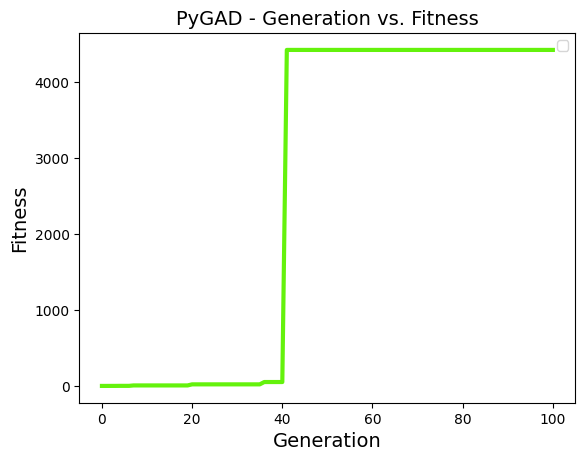

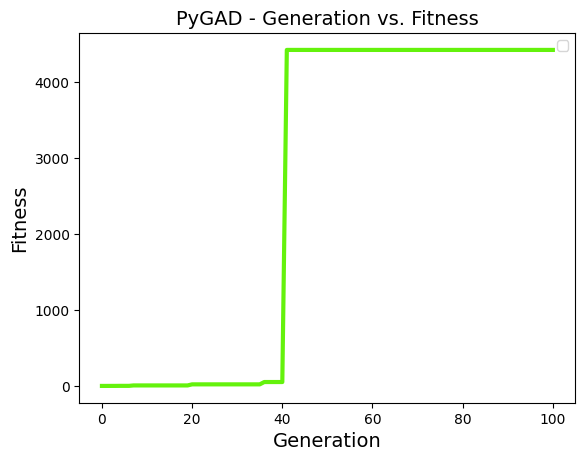

In [3]:
inputs = [0.4, 1, 0, 7, 8]
desired_output = 32

def fitness_func(ga_instance, solution, solution_idx):
    output = np.sum(solution * inputs)
    fitness = 1.0 / (np.abs(output - desired_output) + 0.000001)
    return fitness

ga_instance = pygad.GA(num_generations=100,
                       num_genes=len(inputs), 
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       sol_per_pop=10, 
                       mutation_probability=0.1, # Adjusted for typical use
                       mutation_type="random")

ga_instance.run()

ga_instance.plot_fitness()


## Entrenant xarxes neuronals amb algoritmes genètics

In [4]:

diabetes = load_breast_cancer(as_frame = True)
data = diabetes['data']
target = diabetes['target']
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Separarem ara la base de dades en train i test

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target)

### Creant la xarxa neuronalç

Crearem una petita xarxa neuronal amb Tensorflow

In [130]:
model = Sequential()
model.add(Input(x_train.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 248       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)


Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Programant l'algorisme genètic

KerasGA permetrà aplicar de forma fàcil un algoritme genètic sobre un model desenvolupat en keras. Els paràmetres són el model i el número d'individus de la població.

In [151]:

keras_ga = kerasga.KerasGA(
    model = model,
    num_solutions = 20
)

### Definició de la fitness function

In [152]:
from sklearn.metrics import accuracy_score, f1_score

 
def fitness_func(ga_instance, solution, solution_idx):
    global model, x_train, y_train
    
    weights_matrix = kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
    model.set_weights(weights=weights_matrix)
    
    predictions = model.predict(x_train, verbose=0)
    predictions_binary = (predictions > 0.5).astype(np.int32)  
    
    bce = BinaryCrossentropy()
    loss = bce(y_train, predictions).numpy() 
    
    acc = accuracy_score(y_train, predictions_binary)
    f1 = f1_score(y_train, predictions_binary)
    
    fitness = (acc + f1) / (loss + 0.0001)
    
    return fitness

### Programant un callback

Programarem un callback per saber com està evolucionant el nostre model. 

In [153]:
fitness_evol = []
best_model = None
best_acc = 0

def callback_generation(ga_instance):
  global fitness_evol, best_model, best_acc
  fitness_evol.append(ga_instance.best_solution()[1])
  generation = ga_instance.generations_completed
  best_model_weights = ga_instance.best_solution()[0]  # The best model parameters/weights

  if generation % 1 == 0:
    best_weights_matrix = kerasga.model_weights_as_matrix(model=model, weights_vector=best_model_weights)
    model.set_weights(weights=best_weights_matrix)
    pred = model.predict(x_test, verbose=0)
    threshold = 0.5
    binary_predictions = (pred >= threshold).astype(int)
    accuracy = np.mean(y_test == binary_predictions.flatten())
    if accuracy > best_acc:
      best_acc = accuracy
      best_model = best_weights_matrix
    print(f"Generation {generation}. Fitness: {ga_instance.best_solution()[1]} Accuracy: {accuracy:.2f}")




In [155]:
num_generations = 15
num_parents_mating = 2
initial_population = keras_ga.population_weights

ga_optimizer = pygad.GA(
    num_generations=num_generations, 
    num_parents_mating=num_parents_mating, 
    initial_population=initial_population,
    fitness_func=fitness_func,
    on_generation=callback_generation
    )

ga_optimizer.run()


C:\Users\rmate\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 1. Fitness: 0.23534786798595664 Accuracy: 0.66
Generation 2. Fitness: 0.23534786798595664 Accuracy: 0.66
Generation 3. Fitness: 0.23534786798595664 Accuracy: 0.66
Generation 4. Fitness: 0.23534786798595664 Accuracy: 0.66
Generation 5. Fitness: 0.23534786798595664 Accuracy: 0.66
Generation 6. Fitness: 0.23534786798595664 Accuracy: 0.66
Generation 7. Fitness: 0.23534786798595664 Accuracy: 0.66


<Axes: >

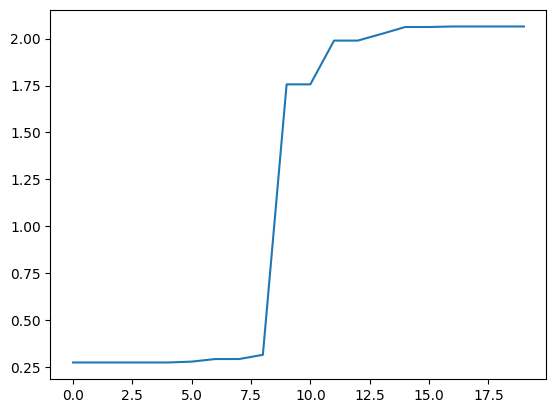

In [143]:
sns.lineplot(
    x = range(len(fitness_evol)),
    y = fitness_evol
)

In [148]:
from sklearn.metrics import confusion_matrix, auc
import numpy as np

model.set_weights(weights=best_model)
pred = model.predict(x_test, verbose=0)
threshold = 0.5
binary_predictions = (pred >= threshold).astype(int)
print(confusion_matrix(y_test, binary_predictions))
accuracy = np.mean(y_test == binary_predictions.flatten())
print(f"Accuracy: {accuracy:.2f}")

TypeError: object of type 'NoneType' has no len()

In [141]:
y_test.value_counts()

target
1    94
0    49
Name: count, dtype: int64